In [ ]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import scipy.stats
import requests
from urllib.parse import urlencode
from scipy import stats
from seaborn_qqplot import pplot
import pingouin as pg

In [ ]:
# groups - был получен сразу
# groups_add пришел через два дня дополнительно

path_to_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
path_to_group_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
path_to_checks =  'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
path_to_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'

In [ ]:
def getting(path):
    token = 'y0_AgAAAAAXeCOsAAwfpgAAAAEK1g68AADatCkcGiZNRYhuspJA9Qt9KeRApw'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=path))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url


In [ ]:
groups = pd.read_csv(getting(path_to_groups), sep = ';')
group_add = pd.read_csv(getting(path_to_group_add))
checks = pd.read_csv(getting(path_to_checks), sep = ';')
active_studs = pd.read_csv(getting(path_to_active_studs), sep = ';')

In [ ]:
# Столбцы к одному имени
active_studs = active_studs.rename(columns = {'student_id':'id'})
checks = checks.rename(columns = {'student_id':'id'})
group_add.columns = groups.columns
# Проверка на уникальность
print(active_studs['id'].duplicated().any())
print(checks['id'].duplicated().any())
print(group_add['id'].duplicated().any())
print(groups['id'].duplicated().any())


False
False
False
False


In [ ]:
# Удаление лишнего, на случай если какие то id были отправлены дважды
group_new = pd.concat([groups,group_add]).drop_duplicates(subset = 'id')

In [ ]:
# Общий вид, количественно
active_studs.merge(group_new, how = 'inner', on = 'id').groupby('grp').agg({'id':'count'})

,id
grp,
A,1538
B,6803


Пользователей группы "B" значительно больше, необходимо учитывать это в дальнейших расчетах

In [ ]:
checks.shape

(541, 2)

In [ ]:
checks.merge(active_studs, how = 'inner', on = 'id').shape

(392, 2)

от 149 пользователей прошла оплата, несмотря на то, что на сайте их не было.
Не учитываем в расчетах - сбой системы

In [ ]:
# Конечная таблица для расчетов
visitors = checks.merge(active_studs, how = 'inner', on = 'id')

<Axes: xlabel='grp', ylabel='rev'>

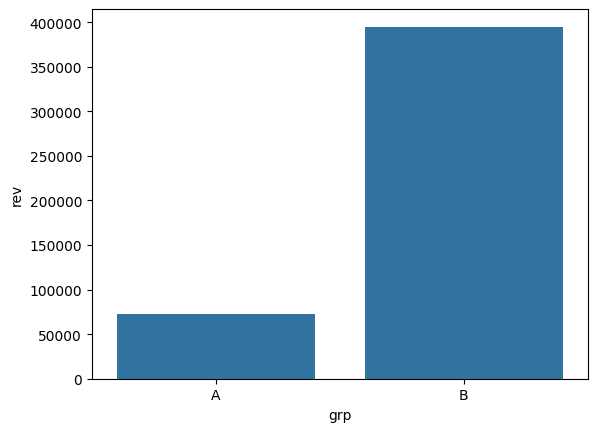

In [ ]:
# Выручка
combined_pays = visitors.merge(group_new, how = 'inner', on='id')
sns.barplot(data = round(combined_pays.groupby('grp', as_index = False).agg({'rev':'sum'}), 2), x = 'grp', y = 'rev')

Большое значение оказывает количество пользователей группы B

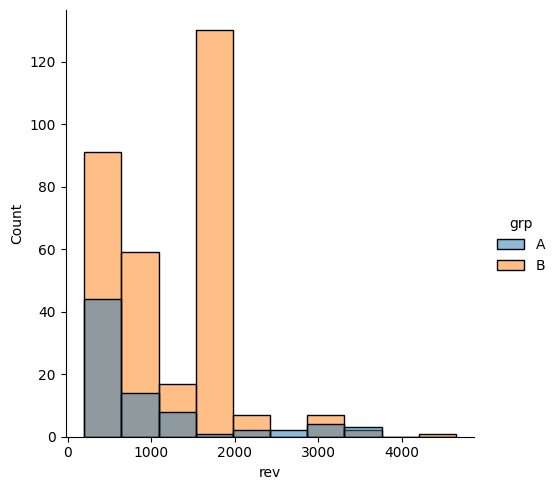

In [ ]:
sns.displot(data = combined_pays, x = 'rev', hue = 'grp', bins = 10)

<Axes: xlabel='grp', ylabel='rev'>

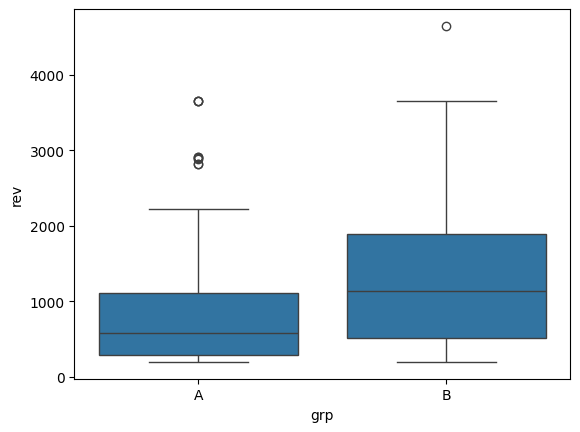

In [ ]:
sns.boxplot(data = combined_pays, x  = 'grp', y = "rev")

Распределение не нормальное, есть выбросы

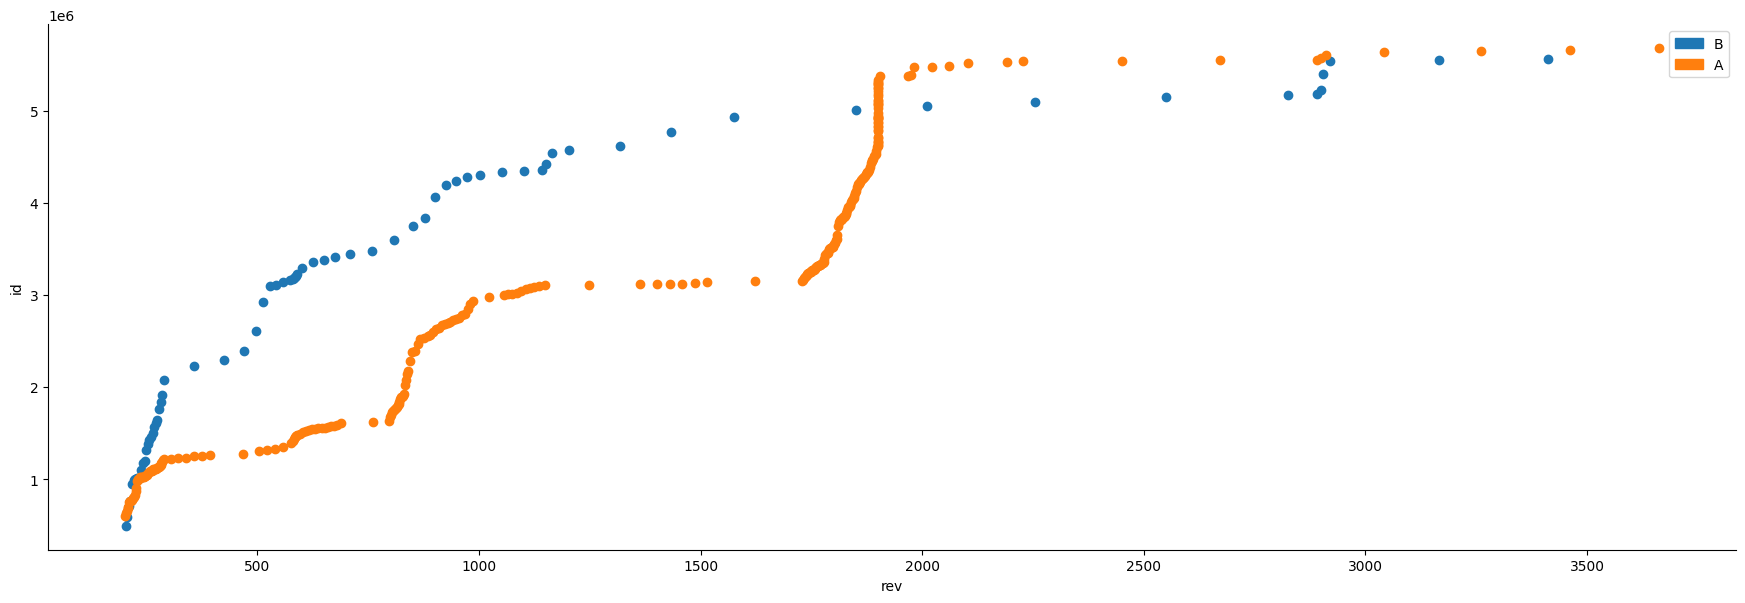

In [ ]:
pplot(combined_pays, x = "rev", y = "id", kind='qq', hue = 'grp',height=6, aspect=3)

Визуально отличаются между собой, но не понятно насколько.
Провести тест

In [ ]:
scipy.stats.levene(combined_pays.query('grp == "A"')['rev'], combined_pays.query('grp == "B"')['rev'])

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Разница дисперсий статистически не значима. Большое количство измерений


In [ ]:

for_grp_A = combined_pays.query('grp == "A"')['rev']
for_grp_B = combined_pays.query('grp == "B"')['rev']

pg.ttest(x=for_grp_A, y=for_grp_B, correction=False )

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.13378,390,two-sided,0.001856,"[-527.74, -120.84]",0.39646,14.001,0.878211


p - значение ниже 0,05 отсюда мы можем предположить, что целевая группа дает нам большую выручку.

<Axes: xlabel='grp', ylabel='rev'>

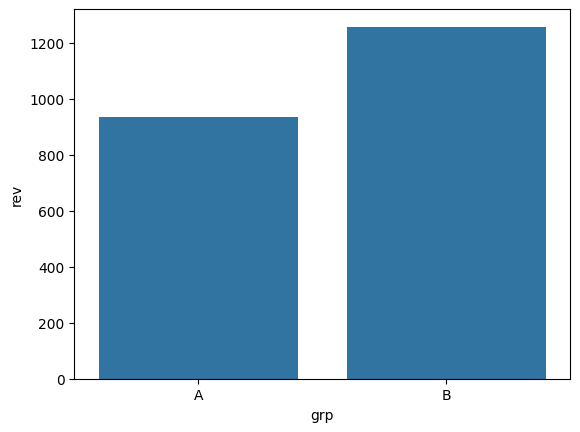

In [ ]:
# Средний чек
sns.barplot(data = round(combined_pays.groupby('grp', as_index = False).agg({'rev':'mean'}), 2), x = 'grp', y = 'rev')

Cредний чек не так зависит от разцы размеров выборок, справочно подтверждает вывод.


<Axes: xlabel='grp', ylabel='rev'>

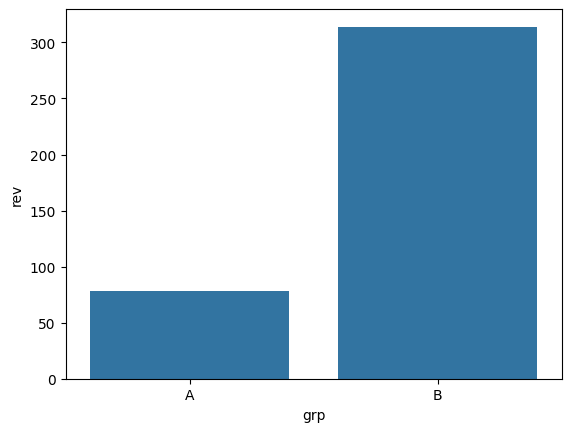

In [ ]:
# Частота оплат
sns.barplot(data = round(combined_pays.groupby('grp', as_index = False).agg({'rev':'count'}), 2), x = 'grp', y = 'rev')

Разница в количестве пользователей.

In [ ]:
# Hfcxtn rjydthcbb
for_CR = active_studs.merge(group_new, how = 'inner', on = 'id').merge(checks, how = 'left', on = 'id').fillna(0)

for_CR['pay?'] = for_CR['rev'].apply(lambda x: 0 if x == 0 else 1)


purchase_A = for_CR.query('rev != 0 & grp == "A"')['id'].count()
Total_A = for_CR.query('grp == "A"')['id'].count()

purchase_B = for_CR.query('rev != 0 & grp == "B"')['id'].count()
Total_B = for_CR.query('grp == "B"')['id'].count()

CR_A = purchase_A / Total_A * 100
CR_B = purchase_B / Total_B * 100

CR = pd.DataFrame({'groups':['A', 'B'], 'CR':[round(CR_A,2), round(CR_B,2)]})

<Axes: xlabel='groups', ylabel='CR'>

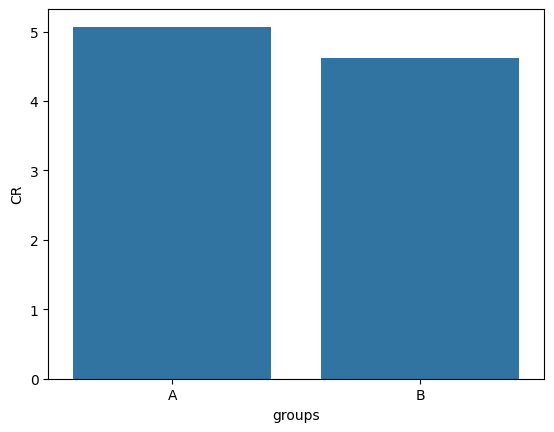

In [ ]:
sns.barplot(data = CR, x = 'groups', y = 'CR')

# Конверсия снижена

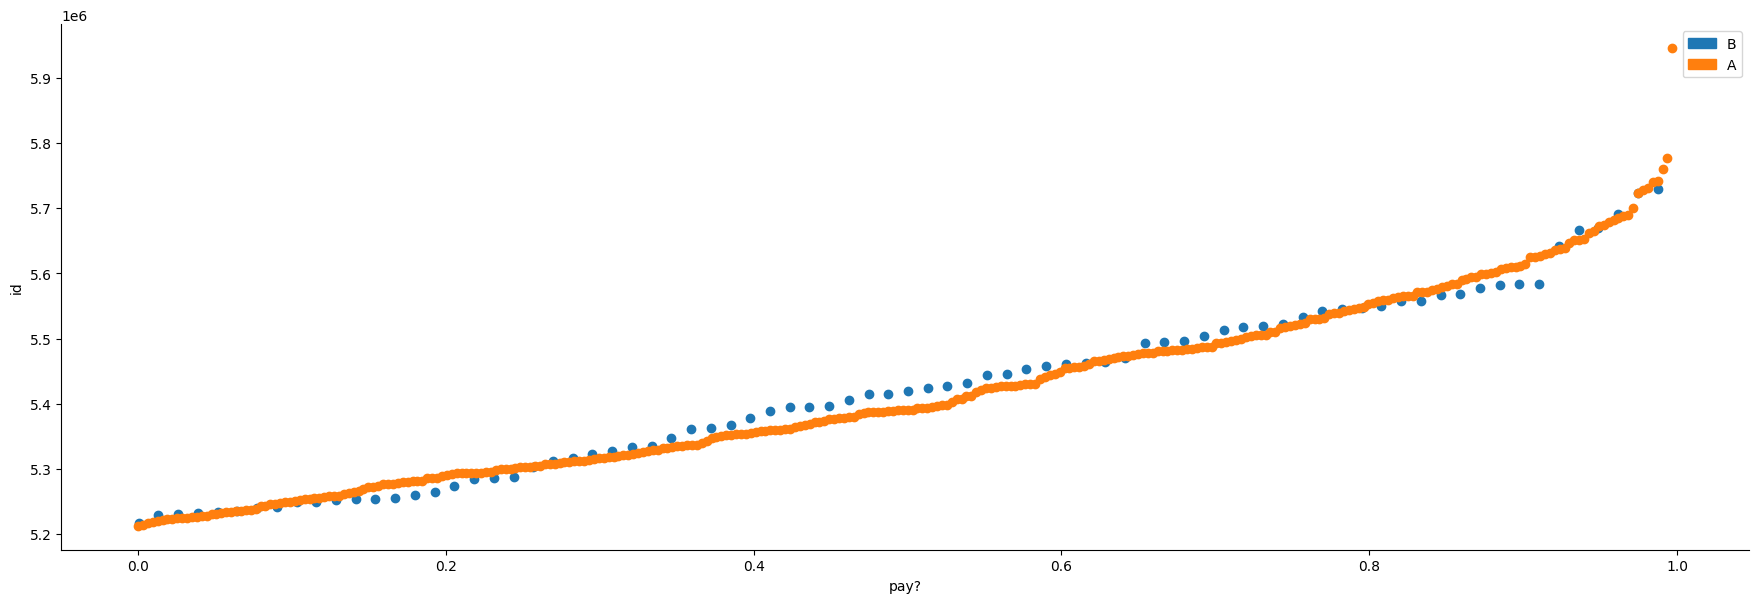

In [ ]:
pplot(for_CR, x = "pay?", y = "id", kind='qq', hue = 'grp',height=6, aspect=3)

Сильное сходство

In [ ]:
scipy.stats.levene(for_CR.query('grp == "A"')['pay?'], for_CR.query('grp == "B"')['pay?'])

LeveneResult(statistic=0.5820524099411407, pvalue=0.44553054513518253)

In [ ]:
pg.ttest(x=for_CR.query('grp == "A"')['pay?'], y=for_CR.query('grp == "B"')['pay?'], correction=False )

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.762924,8339,two-sided,0.445531,"[-0.01, 0.02]",0.021541,0.043,0.118865


Разница статистически не значима. Данные о том, что новая механика повышает выручку при этом не снижает конверсию подтверждены тестами на основе полученных данных.